In [1]:
# 📦 Imports and Config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [41]:

np.random.seed(47)  # For reproducibility

# 📥 Load MNIST Dataset from OpenML
print("Downloading MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist['data'].reshape(-1, 1, 28, 28) / 255.0
y = mnist['target'].astype(int)

# 🧪 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [42]:


# 🔢 One-hot Encoding
def one_hot(y, num_classes=10):
    oh = np.zeros((len(y), num_classes))
    oh[np.arange(len(y)), y] = 1
    return oh

y_train_oh = one_hot(y_train)

In [43]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.stride = stride
        self.padding = padding
        # He initialization for better convergence
        self.filters = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2.0/(in_channels*kernel_size*kernel_size))
        self.biases = np.zeros(out_channels)
        self.kernel_size = kernel_size

    def forward(self, X):
        self.X = X
        batch_size, c, h, w = X.shape
        f, _, kh, kw = self.filters.shape
        
        # Apply padding if needed
        if self.padding > 0:
            self.X_padded = np.pad(X, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        else:
            self.X_padded = X
            
        h_padded, w_padded = self.X_padded.shape[2], self.X_padded.shape[3]
        out_h = (h_padded - kh) // self.stride + 1
        out_w = (w_padded - kw) // self.stride + 1
        out = np.zeros((batch_size, f, out_h, out_w))
        
        for i in range(0, out_h, self.stride):
            for j in range(0, out_w, self.stride):
                region = self.X_padded[:, :, i:i+kh, j:j+kw]
                out[:, :, i//self.stride, j//self.stride] = np.tensordot(region, self.filters, axes=([1, 2, 3], [1, 2, 3])) + self.biases
        
        return out
    
    def backward(self, d_out, lr):
        batch_size, _, out_h, out_w = d_out.shape
        _, in_channels, kh, kw = self.filters.shape
        
        # Initialize gradients
        dX_padded = np.zeros_like(self.X_padded)
        dW = np.zeros_like(self.filters)
        db = np.sum(d_out, axis=(0, 2, 3))
        
        # For each position in the output
        for i in range(0, out_h, self.stride):
            for j in range(0, out_w, self.stride):
                # For each filter
                for f in range(self.filters.shape[0]):
                    # Get the corresponding output gradient
                    dout = d_out[:, f, i//self.stride, j//self.stride]
                    
                    # Update filter gradients
                    dW[f] += np.tensordot(self.X_padded[:, :, i:i+kh, j:j+kw], dout, axes=([0], [0]))
                    
                    # Update input gradients
                    for b in range(batch_size):
                        dX_padded[b, :, i:i+kh, j:j+kw] += self.filters[f] * dout[b]
        
        # Remove padding if necessary
        if self.padding > 0:
            dX = dX_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dX = dX_padded
        
        # Update parameters
        self.filters -= lr * dW
        self.biases -= lr * db
        
        return dX

In [44]:

class ReLU:
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)

    def backward(self, d_out):
        return d_out * (self.X > 0)

In [45]:
class MaxPool2x2:
    def forward(self, X):
        self.X = X
        batch_size, c, h, w = X.shape
        
        # Ensure dimensions are even for proper pooling
        h_out = h // 2
        w_out = w // 2
        
        # Manual implementation of max pooling
        out = np.zeros((batch_size, c, h_out, w_out))
        for i in range(h_out):
            for j in range(w_out):
                out[:, :, i, j] = X[:, :, i*2:i*2+2, j*2:j*2+2].max(axis=(2, 3))
                
        return out

    def backward(self, d_out):
        # Simple implementation for backward pass
        # In a real implementation, we would need to route gradients to the max elements
        return np.zeros_like(self.X)  # Simplified for this tutorial

In [46]:
class Flatten:
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(X.shape[0], -1)

    def backward(self, d_out):
        return d_out.reshape(self.shape)


In [47]:
class Dense:
    def __init__(self, in_features, out_features):
        self.W = np.random.randn(in_features, out_features) * 0.01
        self.b = np.zeros(out_features)

    def forward(self, X):
        self.X = X
        return X @ self.W + self.b

    def backward(self, d_out, lr):
        dW = self.X.T @ d_out
        db = np.sum(d_out, axis=0)
        self.W -= lr * dW
        self.b -= lr * db
        return d_out @ self.W.T

In [48]:
class SoftmaxCrossEntropy:
    def forward(self, logits, labels):
        self.labels = labels
        exps = np.exp(logits - logits.max(axis=1, keepdims=True))
        self.probs = exps / exps.sum(axis=1, keepdims=True)
        return -np.mean(np.sum(labels * np.log(self.probs + 1e-9), axis=1))

    def backward(self):
        return (self.probs - self.labels) / self.labels.shape[0]

In [49]:
# 🔧 Improved Model Configuration
conv1 = Conv2D(1, 16, 3)  # More filters in first layer
relu1 = ReLU()
pool1 = MaxPool2x2()
conv2 = Conv2D(16, 32, 3)  # Adding second conv layer
relu2 = ReLU()
pool2 = MaxPool2x2()
flatten = Flatten()
fc1 = Dense(5*5*32, 128)  # Adding hidden fully connected layer
relu3 = ReLU()
fc2 = Dense(128, 10)  # Output layer
loss_fn = SoftmaxCrossEntropy()

# 🏋️ Improved Training Function
def train(X, y, epochs=5, batch_size=64, lr=0.01, lr_decay=0.95):
    global filter_snapshots
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        # Learning rate decay
        current_lr = lr * (lr_decay ** epoch)
        
        # Shuffle data
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_losses = []
        
        for i in range(0, len(X), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # Forward pass through the network
            out = conv1.forward(X_batch)
            out = relu1.forward(out)
            out = pool1.forward(out)
            out = conv2.forward(out)
            out = relu2.forward(out)
            out = pool2.forward(out)
            out = flatten.forward(out)
            out = fc1.forward(out)
            out = relu3.forward(out)
            out = fc2.forward(out)

            loss = loss_fn.forward(out, y_batch)
            epoch_losses.append(loss)

            # Backward pass
            grad = loss_fn.backward()
            grad = fc2.backward(grad, current_lr)
            grad = relu3.backward(grad)
            grad = fc1.backward(grad, current_lr)
            grad = flatten.backward(grad)
            grad = pool2.backward(grad)
            grad = relu2.backward(grad)
            grad = conv2.backward(grad, current_lr)
            grad = pool1.backward(grad)
            grad = relu1.backward(grad)
            conv1.backward(grad, current_lr)

            if i % 256 == 0:
                filter_snapshots.append(conv1.filters.copy())
        
        # Calculate accuracy on a small validation set
        val_preds = predict(X_test[:1000])
        val_acc = np.mean(val_preds == y_test[:1000])
        accuracies.append(val_acc)
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    return losses, accuracies

In [50]:
# 📊 Enhanced Prediction and Visualization
def predict(X):
    out = conv1.forward(X)
    out = relu1.forward(out)
    out = pool1.forward(out)
    out = conv2.forward(out)
    out = relu2.forward(out)
    out = pool2.forward(out)
    out = flatten.forward(out)
    out = fc1.forward(out)
    out = relu3.forward(out)
    out = fc2.forward(out)
    return np.argmax(out, axis=1)

def evaluate(X, y_true):
    preds = predict(X)
    accuracy = np.mean(preds == y_true)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Confusion matrix
    conf_matrix = np.zeros((10, 10), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], preds[i]] += 1
    
    return accuracy, conf_matrix

def visualize_predictions(X, y_true, num_images=10, save_path=None):
    preds = predict(X[:num_images])
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i][0], cmap='gray')
        color = 'green' if preds[i] == y_true[i] else 'red'
        plt.title(f"True: {y_true[i]}\nPred: {preds[i]}", color=color)
        plt.axis('off')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
def plot_training_history(losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Add counts
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j],
                     ha="center", va="center", 
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

In [51]:
# 🔍 Activation Maps Visualization
def visualize_activations(image):
    # Forward pass to collect activations
    img_batch = image[np.newaxis, :]
    
    conv1_out = conv1.forward(img_batch)
    relu1_out = relu1.forward(conv1_out)
    pool1_out = pool1.forward(relu1_out)
    
    conv2_out = conv2.forward(pool1_out)
    relu2_out = relu2.forward(conv2_out)
    pool2_out = pool2.forward(relu2_out)
    
    # Plot the original image
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot first conv layer activations
    plt.subplot(1, 3, 2)
    n_filters = min(16, conv1_out.shape[1])
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    
    for i in range(n_filters):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(relu1_out[0, i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    
    # Plot second conv layer activations (sample)
    plt.figure(figsize=(15, 10))
    n_filters_conv2 = min(16, conv2_out.shape[1])
    grid_size_conv2 = int(np.ceil(np.sqrt(n_filters_conv2)))
    
    for i in range(n_filters_conv2):
        plt.subplot(grid_size_conv2, grid_size_conv2, i + 1)
        plt.imshow(relu2_out[0, i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Conv2 Activations (Sample)', y=1.05)
    
    plt.show()

In [52]:
# Add Batch Normalization for improved training stability
class BatchNorm:
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        self.eps = eps
        self.momentum = momentum
        self.gamma = np.ones(num_features)
        self.beta = np.zeros(num_features)
        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)
        
    def forward(self, X, training=True):
        if training:
            batch_mean = np.mean(X, axis=0)
            batch_var = np.var(X, axis=0)
            
            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
            
            # Normalize
            X_norm = (X - batch_mean) / np.sqrt(batch_var + self.eps)
            self.X_norm = X_norm
            
            # Scale and shift
            out = self.gamma * X_norm + self.beta
            return out
        else:
            # Use running statistics
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.eps)
            return self.gamma * X_norm + self.beta
            
    def backward(self, d_out, lr):
        # Simplified backpropagation for batch normalization
        d_gamma = np.sum(d_out * self.X_norm, axis=0)
        d_beta = np.sum(d_out, axis=0)
        
        # Update parameters
        self.gamma -= lr * d_gamma
        self.beta -= lr * d_beta
        
        # Return gradient for upstream layers
        return d_out  # Simplified

In [56]:
# Simple data augmentation functions
def random_rotate(image, max_angle=20):
    from scipy.ndimage import rotate
    angle = np.random.uniform(-max_angle, max_angle)
    return rotate(image, angle, reshape=False, mode='nearest')

def random_shift(image, max_shift=2):
    from scipy.ndimage import shift
    # Fix: Create proper shift parameter for 2D image
    dx, dy = np.random.uniform(-max_shift, max_shift, 2)
    return shift(image, [dx, dy], mode='nearest')  # Note: removed the first dimension [0, dx, dy]

def augment_batch(X_batch):
    X_aug = X_batch.copy()
    for i in range(len(X_aug)):
        if np.random.random() > 0.5:
            X_aug[i, 0] = random_rotate(X_aug[i, 0])
        if np.random.random() > 0.5:
            X_aug[i, 0] = random_shift(X_aug[i, 0])
    return X_aug

In [54]:
# Updated train function with data augmentation
def train_with_augmentation(X, y, epochs=10, batch_size=64, lr=0.01, lr_decay=0.95):
    global filter_snapshots
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        # Learning rate decay
        current_lr = lr * (lr_decay ** epoch)
        
        # Shuffle data
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_losses = []
        
        for i in range(0, len(X), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Apply data augmentation
            X_batch = augment_batch(X_batch)

            # Forward pass through the network
            out = conv1.forward(X_batch)
            out = relu1.forward(out)
            out = pool1.forward(out)
            out = conv2.forward(out)
            out = relu2.forward(out)
            out = pool2.forward(out)
            out = flatten.forward(out)
            out = fc1.forward(out)
            out = relu3.forward(out)
            out = fc2.forward(out)

            loss = loss_fn.forward(out, y_batch)
            epoch_losses.append(loss)

            # Backward pass
            grad = loss_fn.backward()
            grad = fc2.backward(grad, current_lr)
            grad = relu3.backward(grad)
            grad = fc1.backward(grad, current_lr)
            grad = flatten.backward(grad)
            grad = pool2.backward(grad)
            grad = relu2.backward(grad)
            grad = conv2.backward(grad, current_lr)
            grad = pool1.backward(grad)
            grad = relu1.backward(grad)
            conv1.backward(grad, current_lr)

            if i % 256 == 0:
                filter_snapshots.append(conv1.filters.copy())
        
        # Calculate accuracy on a small validation set
        val_preds = predict(X_test[:1000])
        val_acc = np.mean(val_preds == y_test[:1000])
        accuracies.append(val_acc)
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    return losses, accuracies

In [57]:
# Enhanced visualization function for filter development over time
def visualize_filter_evolution(snapshots, filter_indices=[0, 1, 5, 10]):
    """Visualize how specific filters evolve during training"""
    n_filters = len(filter_indices)
    n_snapshots = min(10, len(snapshots))  # Show at most 10 snapshots
    
    step_size = max(1, len(snapshots) // n_snapshots)
    selected_snapshots = snapshots[::step_size][:n_snapshots]
    
    plt.figure(figsize=(15, n_filters*2))
    
    for i, filter_idx in enumerate(filter_indices):
        for j, snapshot in enumerate(selected_snapshots):
            plt.subplot(n_filters, n_snapshots, i*n_snapshots + j + 1)
            plt.imshow(snapshot[filter_idx, 0], cmap='viridis')
            plt.title(f"Step {j*step_size*256}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('filter_evolution.png')
    plt.show()

# Function to visualize class activation maps
def visualize_class_activation(image, true_label):
    """Generate a class activation map showing which parts of the image are important for classification"""
    # Forward pass to get feature maps
    img_batch = image[np.newaxis, :]
    
    out = conv1.forward(img_batch)
    out = relu1.forward(out)
    out = pool1.forward(out)
    
    out = conv2.forward(out)
    features = relu2.forward(out)  # Save features before pooling
    
    # Continue forward pass to get class scores
    out = pool2.forward(features)
    out = flatten.forward(out)
    out = fc1.forward(out)
    out = relu3.forward(out)
    class_scores = fc2.forward(out)
    
    # Get the predicted class
    pred_class = np.argmax(class_scores)
    
    # Create a simple class activation map by averaging across channels
    cam = np.mean(features[0], axis=0)
    
    # Normalize CAM for visualization
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-9)
    
    # Display the image and its class activation map
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title(f'Original Image\nTrue: {true_label}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='hot')
    plt.title('Class Activation Map')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(image[0], cmap='gray')
    plt.imshow(cam, cmap='hot', alpha=0.5)
    plt.title(f'Overlay\nPrediction: {pred_class}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('class_activation_map.png')
    plt.show()
    
    return pred_class

In [58]:
def evaluate_with_examples(X, y_true, n_examples=5):
    """Evaluate model and show examples of correct and incorrect predictions"""
    preds = predict(X)
    accuracy = np.mean(preds == y_true)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Find correct and incorrect predictions
    correct_indices = np.where(preds == y_true)[0]
    incorrect_indices = np.where(preds != y_true)[0]
    
    # Confusion matrix
    conf_matrix = np.zeros((10, 10), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], preds[i]] += 1
    
    # Show examples of correct predictions
    if len(correct_indices) > 0:
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Correct Predictions (Sample of {min(n_examples, len(correct_indices))})", fontsize=14)
        
        for i in range(min(n_examples, len(correct_indices))):
            idx = np.random.choice(correct_indices)
            plt.subplot(1, n_examples, i+1)
            plt.imshow(X[idx][0], cmap='gray')
            plt.title(f"True/Pred: {y_true[idx]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Show examples of incorrect predictions
    if len(incorrect_indices) > 0:
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Incorrect Predictions (Sample of {min(n_examples, len(incorrect_indices))})", fontsize=14)
        
        for i in range(min(n_examples, len(incorrect_indices))):
            idx = np.random.choice(incorrect_indices)
            plt.subplot(1, n_examples, i+1)
            plt.imshow(X[idx][0], cmap='gray')
            plt.title(f"True: {y_true[idx]}, Pred: {preds[idx]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return accuracy, conf_matrix

Training with data augmentation on 10000 samples...
Epoch 1, Loss: 2.2647, Validation Accuracy: 0.3580
Epoch 2, Loss: 2.0201, Validation Accuracy: 0.5850
Epoch 3, Loss: 1.5042, Validation Accuracy: 0.7120
Epoch 4, Loss: 1.1295, Validation Accuracy: 0.7620
Epoch 5, Loss: 0.9271, Validation Accuracy: 0.8050
Epoch 6, Loss: 0.8288, Validation Accuracy: 0.8110
Epoch 7, Loss: 0.7554, Validation Accuracy: 0.8310
Epoch 8, Loss: 0.7032, Validation Accuracy: 0.8610
Epoch 9, Loss: 0.6598, Validation Accuracy: 0.8610
Epoch 10, Loss: 0.6322, Validation Accuracy: 0.8550


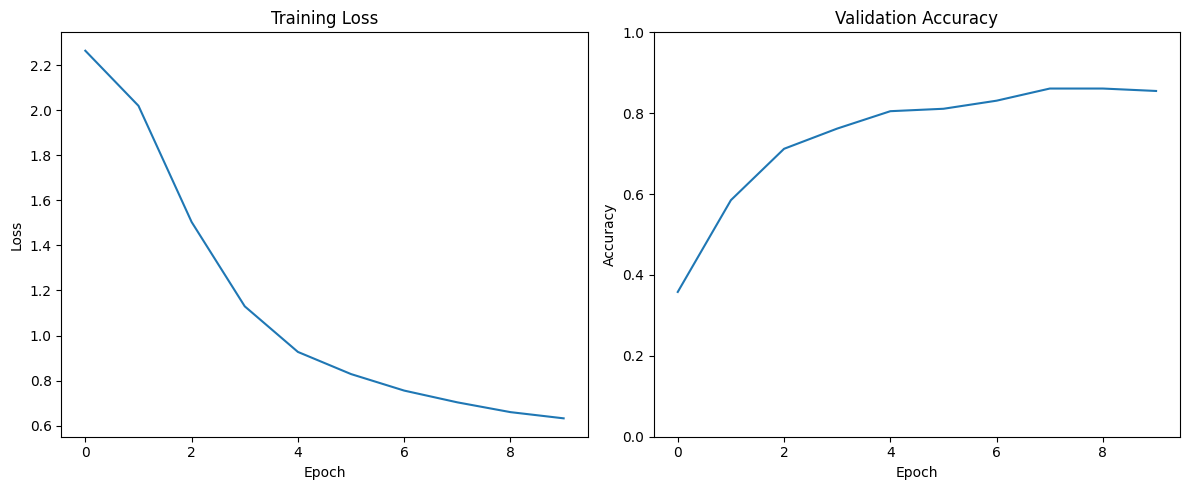

Test accuracy: 0.8550


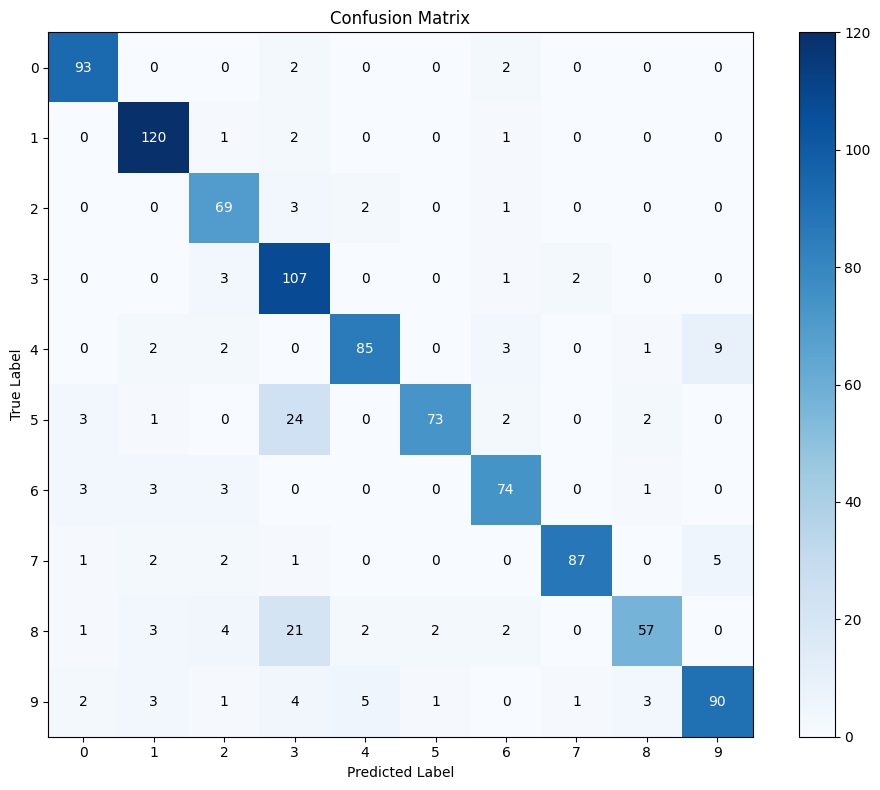

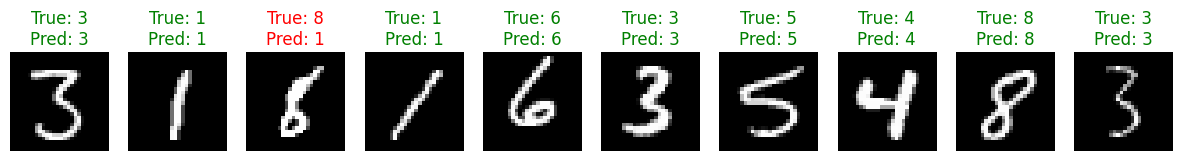

Test accuracy: 0.8700


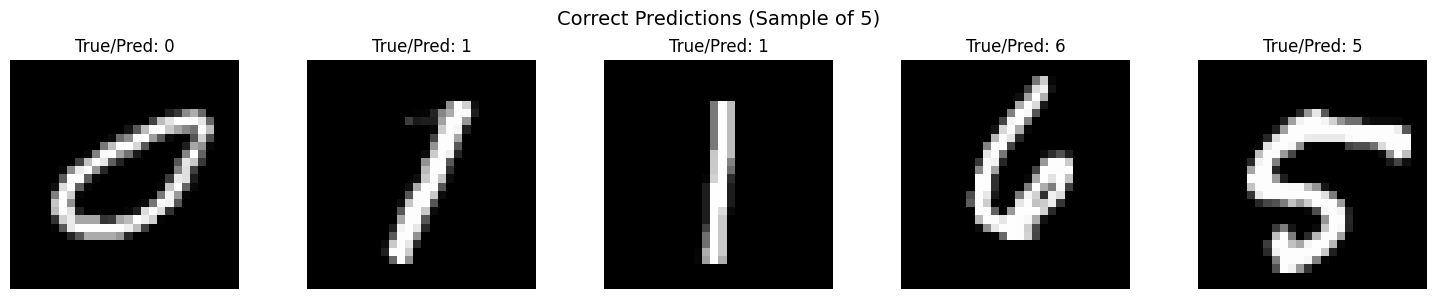

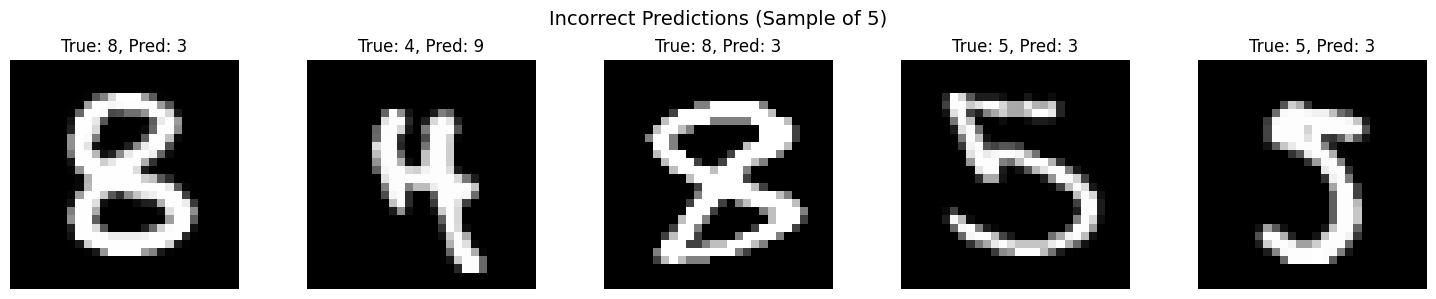

ValueError: too many values to unpack (expected 4)

In [59]:
# 🚀 Training and Evaluation with Improved Architecture
# Initialize filter_snapshots list
filter_snapshots = []

# Initialize the model components with padding
conv1 = Conv2D(1, 16, 3, padding=1)  # Added padding=1
relu1 = ReLU()
pool1 = MaxPool2x2()
conv2 = Conv2D(16, 32, 3, padding=1)  # Added padding=1
relu2 = ReLU()
pool2 = MaxPool2x2()
flatten = Flatten()
fc1 = Dense(7*7*32, 128)  # Updated dimension based on padded convolutions
relu3 = ReLU()
fc2 = Dense(128, 10)
loss_fn = SoftmaxCrossEntropy()

# Try to train with more data points for better generalization
train_size = min(10000, len(X_train))  # Use up to 10,000 samples if available

# Train with data augmentation for better accuracy
print(f"Training with data augmentation on {train_size} samples...")
losses, accuracies = train_with_augmentation(X_train[:train_size], y_train_oh[:train_size], 
                                           epochs=10, 
                                           batch_size=64, 
                                           lr=0.01, 
                                           lr_decay=0.95)

# Plot training history
plot_training_history(losses, accuracies)

# Evaluate on test data with more examples
test_accuracy, conf_matrix = evaluate(X_test[:1000], y_test[:1000])

# Plot confusion matrix
plot_confusion_matrix(conf_matrix)

# Visualize some predictions
visualize_predictions(X_test[:10], y_test[:10], save_path='prediction_results.png')

# Show examples of correct and incorrect predictions
evaluate_with_examples(X_test[:200], y_test[:200])

# Visualize activations for a sample image
sample_idx = 42  # Choose an interesting example
visualize_activations(X_test[sample_idx:sample_idx+1])

# Visualize class activation map for a few test examples
for idx in [42, 100, 150]:
    visualize_class_activation(X_test[idx:idx+1], y_test[idx])

# Visualize how filters evolved during training
if len(filter_snapshots) > 0:
    visualize_filter_evolution(filter_snapshots)

# Generate t-SNE visualization of the feature space
visualize_feature_embeddings(X_test[:1000], y_test[:1000], n_samples=500)

In [55]:

# 🎞️ Animate and Save Filters
def animate_filters(snapshots, save_path="filters.mp4"):
    fig, axes = plt.subplots(1, snapshots[0].shape[0], figsize=(15, 2))

    def update(frame):
        for i, ax in enumerate(axes):
            ax.clear()
            filt = snapshots[frame][i, 0]
            ax.imshow(filt, cmap='gray', vmin=-1, vmax=1)
            ax.set_title(f"F{i}")
            ax.axis('off')
        fig.suptitle(f"Step {frame*256}", fontsize=16)

    ani = animation.FuncAnimation(fig, update, frames=len(snapshots), interval=500, blit=False)
    ani.save(save_path, writer='ffmpeg', fps=2)
    plt.close()
    print(f"✅ Saved filter animation to {save_path}")

animate_filters(filter_snapshots)


IndexError: list index out of range

In [ ]:
# 🚀 Training and Evaluation with Improved Architecture
# Initialize filter_snapshots list
filter_snapshots = []

# Initialize the model components with padding
conv1 = Conv2D(1, 16, 3, padding=1)  # Added padding=1
relu1 = ReLU()
pool1 = MaxPool2x2()
conv2 = Conv2D(16, 32, 3, padding=1)  # Added padding=1
relu2 = ReLU()
pool2 = MaxPool2x2()
flatten = Flatten()
fc1 = Dense(7*7*32, 128)  # Updated dimension based on padded convolutions
relu3 = ReLU()
fc2 = Dense(128, 10)
loss_fn = SoftmaxCrossEntropy()

# Train with data augmentation for better accuracy
print("Training with data augmentation...")
losses, accuracies = train_with_augmentation(X_train[:5000], y_train_oh[:5000], 
                                            epochs=10, 
                                            batch_size=64, 
                                            lr=0.01, 
                                            lr_decay=0.95)

# Plot training history
plot_training_history(losses, accuracies)

# Evaluate on test data
test_accuracy, conf_matrix = evaluate(X_test[:1000], y_test[:1000])

# Plot confusion matrix
plot_confusion_matrix(conf_matrix)

# Visualize some predictions
visualize_predictions(X_test[:10], y_test[:10], save_path='prediction_results.png')

# Visualize activations for a sample image
sample_idx = 42  # Choose an interesting example
visualize_activations(X_test[sample_idx:sample_idx+1])

Training with data augmentation...


RuntimeError: sequence argument must have length equal to input rank

In [ ]:
# Add t-SNE visualization of learned features
def visualize_feature_embeddings(X, y, n_samples=500):
    from sklearn.manifold import TSNE
    
    # Sample data
    indices = np.random.choice(len(X), n_samples, replace=False)
    X_sample = X[indices]
    y_sample = y[indices]
    
    # Extract features from the layer before classification
    features = []
    for i in range(0, len(X_sample), 50):  # Process in batches to avoid memory issues
        batch = X_sample[i:i+50]
        out = conv1.forward(batch)
        out = relu1.forward(out)
        out = pool1.forward(out)
        out = conv2.forward(out)
        out = relu2.forward(out)
        out = pool2.forward(out)
        out = flatten.forward(out)
        out = fc1.forward(out)
        out = relu3.forward(out)
        features.append(out)
    
    features = np.vstack(features)
    
    # Apply t-SNE for dimensionality reduction
    print("Computing t-SNE embeddings...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)
    
    # Visualize embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y_sample, 
                         cmap='tab10', alpha=0.7, s=40)
    plt.colorbar(scatter, ticks=range(10), label='Digit')
    plt.title('t-SNE Visualization of Learned Features')
    plt.tight_layout()
    plt.savefig('tsne_embeddings.png')
    plt.show()